In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ppm = PyramidPooling(
            16, [16, 6, 3, 2, 1], 16, 16
        )
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(31, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.ppm(x)
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─PyramidPooling: 1-3                    [64, 31, 16, 16]          --
│    └─AdaptiveAvgPool2d: 2-5            [64, 16, 16, 16]          --
│    └─conv2DBatchNormRelu: 2-6          [64, 3, 16, 16]           --
│    │    └─Conv2d: 3-1                  [64, 3, 16, 16]           48
│    │    └─BatchNorm2d: 3-2             [64, 3, 16, 16]           6
│    │    └─ReLU: 3-3                    [64, 3, 16, 16]           --
│    │    └─Dro

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 1.0984 Acc: 0.3110
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 1.0706 Acc: 0.4224


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 1.0739 Acc: 0.4086
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


train Loss: 1.0342 Acc: 0.4935


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 1.0572 Acc: 0.3986
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 1.0073 Acc: 0.5245


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.64it/s]


val Loss: 0.9784 Acc: 0.5871
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.9926 Acc: 0.5536


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.9558 Acc: 0.6052
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.9839 Acc: 0.5576


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.65it/s]


val Loss: 0.9825 Acc: 0.5105
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


train Loss: 0.9827 Acc: 0.5495


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.65it/s]


val Loss: 0.9639 Acc: 0.5933
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


train Loss: 0.9613 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.9125 Acc: 0.6633
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


train Loss: 0.9581 Acc: 0.5886


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.52it/s]


val Loss: 0.9221 Acc: 0.5976
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


train Loss: 0.9626 Acc: 0.5826


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.44it/s]


val Loss: 0.9358 Acc: 0.6024
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


train Loss: 0.9559 Acc: 0.5796


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.9383 Acc: 0.5600
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.9403 Acc: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.50it/s]


val Loss: 0.8957 Acc: 0.6281
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.9342 Acc: 0.5996


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.62it/s]


val Loss: 0.9536 Acc: 0.5657
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


train Loss: 0.9316 Acc: 0.6026


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.66it/s]


val Loss: 0.9130 Acc: 0.6424
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


train Loss: 0.9305 Acc: 0.6066


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.71it/s]


val Loss: 0.8737 Acc: 0.6881
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.9198 Acc: 0.6166


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.8784 Acc: 0.6829
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.9213 Acc: 0.6326


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.8677 Acc: 0.6829
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


train Loss: 0.9136 Acc: 0.6386


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 0.9015 Acc: 0.6105
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.9085 Acc: 0.6286


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.8469 Acc: 0.7119
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.9039 Acc: 0.6306


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.41it/s]


val Loss: 0.9410 Acc: 0.6052
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.9070 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8917 Acc: 0.6510
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.9124 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8707 Acc: 0.6657
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.8956 Acc: 0.6537


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8501 Acc: 0.7048
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


train Loss: 0.8986 Acc: 0.6456


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.47it/s]


val Loss: 0.8361 Acc: 0.7295
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


train Loss: 0.8935 Acc: 0.6527


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.40it/s]


val Loss: 0.8545 Acc: 0.6948
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


train Loss: 0.8937 Acc: 0.6426


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.42it/s]


val Loss: 0.8446 Acc: 0.7219
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8853 Acc: 0.6637


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.8311 Acc: 0.7290
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


train Loss: 0.8899 Acc: 0.6537


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]


val Loss: 0.8461 Acc: 0.7100
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


train Loss: 0.8738 Acc: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8412 Acc: 0.7148
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8736 Acc: 0.6667


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.9216 Acc: 0.6257
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


train Loss: 0.8796 Acc: 0.6597


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


val Loss: 0.8676 Acc: 0.6652
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8675 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8137 Acc: 0.7433
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.8671 Acc: 0.6757


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8911 Acc: 0.6119
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


train Loss: 0.8705 Acc: 0.6667


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8535 Acc: 0.6586
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8690 Acc: 0.6707


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.8112 Acc: 0.7481
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8617 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8471 Acc: 0.6795
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.42it/s]


train Loss: 0.8568 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8500 Acc: 0.6843
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8670 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8340 Acc: 0.7262
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.8563 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.8922 Acc: 0.6462
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8642 Acc: 0.6807


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.8111 Acc: 0.7619
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


train Loss: 0.8606 Acc: 0.6757


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.8006 Acc: 0.7681
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8535 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.8040 Acc: 0.7476
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


train Loss: 0.8619 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.8794 Acc: 0.6686
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


train Loss: 0.8552 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


val Loss: 0.8009 Acc: 0.7652
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.8455 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.7904 Acc: 0.7767
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8569 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.88it/s]


val Loss: 0.8042 Acc: 0.7524
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.8444 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8051 Acc: 0.7538
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


train Loss: 0.8583 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.64it/s]


val Loss: 0.8023 Acc: 0.7524
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


train Loss: 0.8434 Acc: 0.7017


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.8120 Acc: 0.7300
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8387 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]

val Loss: 0.8465 Acc: 0.6710


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

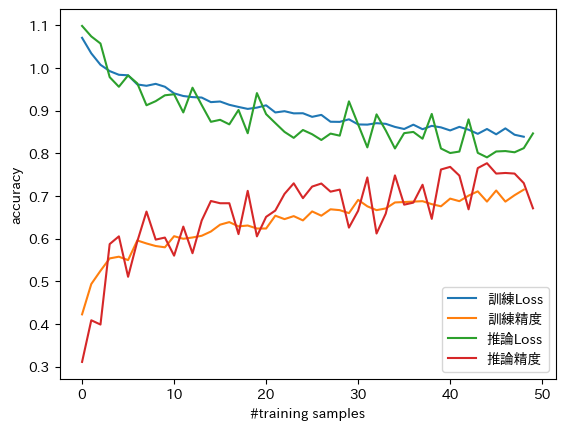

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

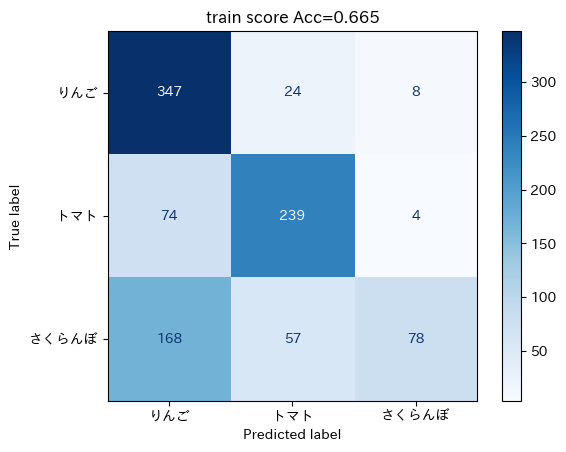

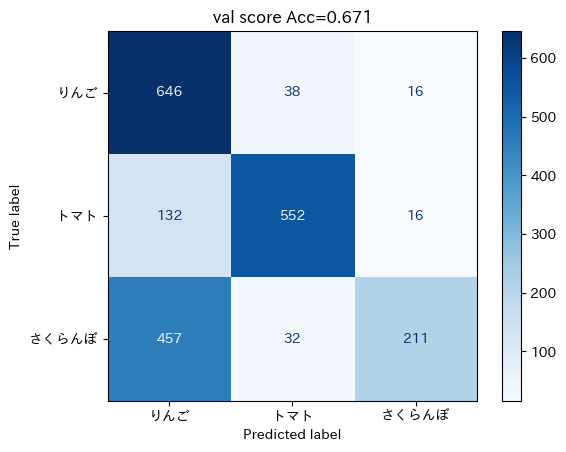

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

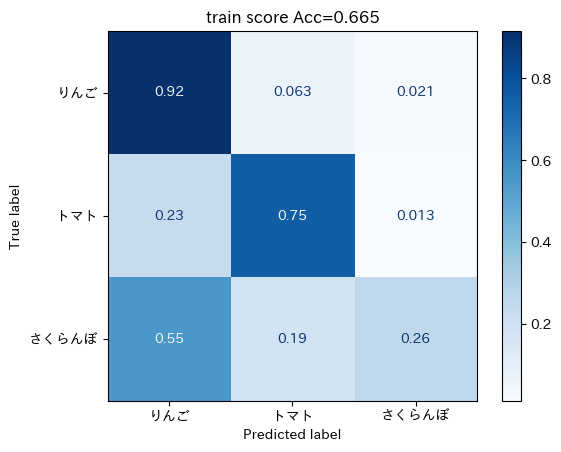

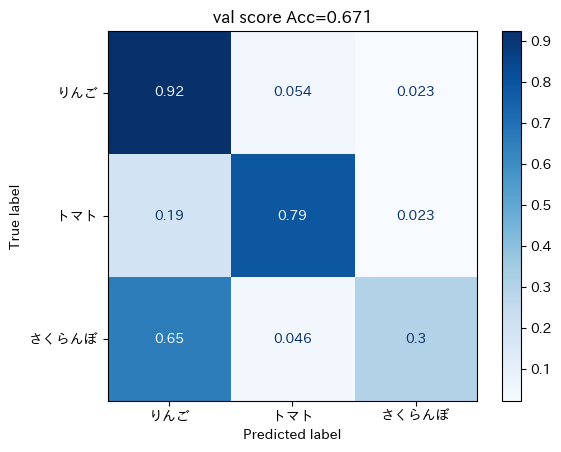

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()